In [2]:
from helix import units
import numpy as np
import helix as hx
def make_default_templates():
    uv_template = hx.get_analytical_template(length=hx.DEFAULT_OF_LENGTH, sampling_dt=hx.DEFAULT_SAMPLING_DT)
    qp_template = hx.get_analytical_template(2 * units.ms, length=hx.DEFAULT_OF_LENGTH,
                                             sampling_dt=hx.DEFAULT_SAMPLING_DT)
    templates = np.array([uv_template, qp_template])

    np.save('plugins/event_rqs/default_templates.npy', templates)
make_default_templates()

## The shape of the template should be (n, 32768), currently is (2, 32768) for the fitting in the module named fit_results.py and optimum_filter for the uv and qp seperately. Fitting mainly done in the fit_result module. 

In [1]:
import json
import os
import shutil
from datetime import datetime, timedelta
import numpy as np
import strax
from bson import json_util
from tqdm import tqdm
import lz4.frame as lz4
import helix as hx
from helix import units
import strax as sx                    
import numba
import pandas as pd
import scipy as sp
import sys
import os
import shutil
from glob import glob
from matplotlib import pyplot as plt
from scipy.signal import medfilt


run_id = 'run10' 
duration = 10  # seconds
raw_data_dir = 'toy_data'  # to save the raw toy data
helix_data_dir = 'test_helix_data'  # to save the run metadata
context = sx.Context(storage=[sx.DataDirectory(helix_data_dir, provide_run_metadata=True), ],
                     register=[hx.MMCRecords,
                               hx.QPTriggers, hx.UVTriggers,
                               hx.Events, hx.NoiseEvents,
                               hx.NoisePSDs, hx.FitResults])    # all the plugins required for getting fit_results

# creating a dictionary of plugins' options that we want to modify. 
config = {'run_metadata_directory': helix_data_dir,      # for the hx.ToyDataRawRecords plugin
          'noise_events_random_seed': 0}  # for the hx.NoiseEvents plugin

context.set_config(config)
events = context.get_array(run_id, 'events')

raw_data = events['channel_data']
raw_data.shape

Loading events: |                   | 0.00 % [00:00<?], #1 (0.03 s). 4422.6 MB/s


(9, 50, 32768)

In [2]:
from scipy.signal import savgol_filter

channel0_data = raw_data[:, 0, :]
channel0_data_excl5 = np.delete(channel0_data, 4, axis=0)
channel0_data_excl5 = np.delete(channel0_data_excl5, 2, axis=0)
processed_traces = []

for ch in range(channel0_data_excl5.shape[0]):
    trace = channel0_data_excl5[ch, :]
    trace_smooth = savgol_filter(trace, window_length=51, polyorder=3)
    processed_traces.append(trace_smooth)

processed_traces = np.array(processed_traces)  
combined_template = np.mean(processed_traces, axis=0)  


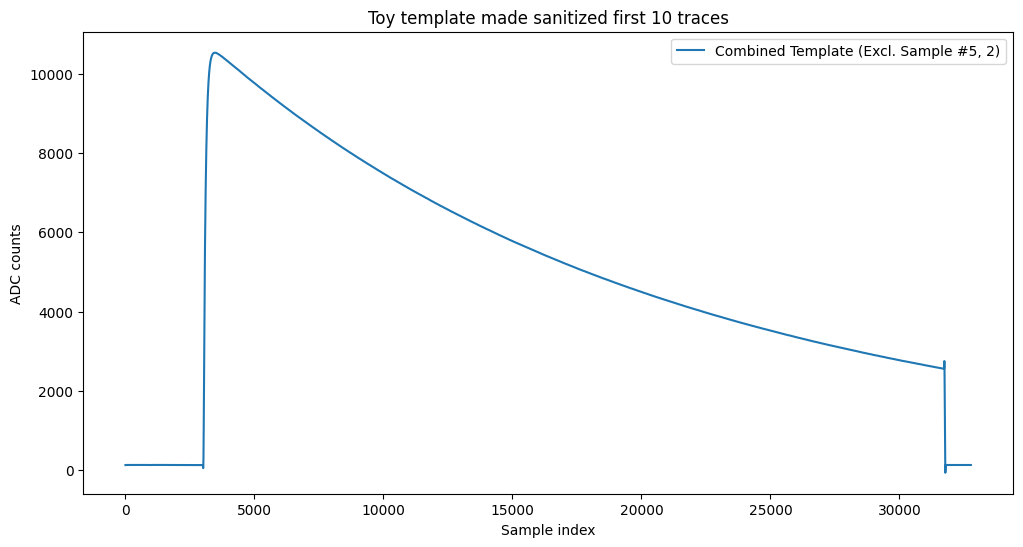

In [3]:

plt.figure(figsize=(12,6))
plt.plot(combined_template, label='Combined Template (Excl. Sample #5, 2)')
plt.xlabel('Sample index')
plt.ylabel('ADC counts')
plt.title('Toy template made sanitized first 10 traces')
plt.legend()
plt.show()


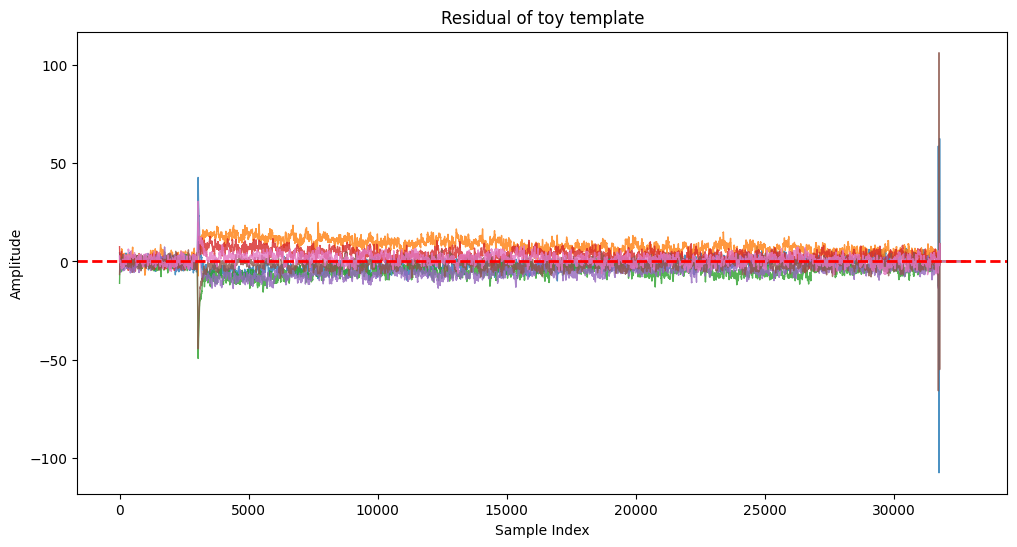

In [4]:
# difference has shape (9, N)
difference = processed_traces - combined_template

# processed_traces has shape (9, N). Each row is one channel’s trace.
# We’ll transpose it so plt.plot(...) will produce one line per channel.
plt.figure(figsize=(12, 6))

# Plot all channels
plt.plot(difference.T, lw=1, alpha=0.8)

# Draw a horizontal red line at y=0
plt.axhline(y=0, color='red', linewidth=2, linestyle='--')

plt.title("Residual of toy template")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")

plt.show()


In [18]:
filtered_template = medfilt(combined_template, kernel_size=81)
if filtered_template.ndim == 1:
     filtered_template = filtered_template.reshape(1, -1)
elif filtered_template.shape[0] != 1:
    raise ValueError("Input array must have shape (L,) or (1, L)")
    
duplicated_array = np.vstack([filtered_template, filtered_template])
np.save("2level2_template.npy", duplicated_array)


In [17]:
duplicated_array.shape


(2, 32768)